## Download the enron dataset

In [1]:
# print("Downloading the Enron dataset")

# import requests
# url = "https://www.cs.cmu.edu/~./enron/enron_mail_20150507.tar.gz"
# filename = "../enron_mail_20150507.tar.gz"
# with open(filename, "wb") as f:
#     r = requests.get(url)
#     f.write(r.content)
# print("Download Complete!")

# print("Unzipping Enron dataset (This may take a while)")
# import tarfile
# tfile = tarfile.open("../enron_mail_20150507.tar.gz")
# tfile.extractall(".")
# tfile.close()

# print("You're ready to go!")

To check on progress, you can cd up one level, then execute <ls -lthr>
Enron dataset should be last item on the list, along with its current size
Download will complete at about 1.82 GB
Download Complete!
Unzipping Enron dataset (This may take a while)
You're ready to go!


Convert all enron email files to csv

In [2]:
import os
import csv
from email.parser import Parser

In [31]:
# Define the root directory of the Enron dataset
MAILDIR_PATH = "./maildir" 
OUTPUT_CSV = "../enron_emails.csv"

In [32]:
# Define the CSV columns
fields = ["file", "message"]

In [33]:
# Function to extract email content from a file
def extract_email(file_path):
    with open(file_path, "r", encoding="latin1") as file:
        data = file.read()
    relative_path = os.path.relpath(file_path, MAILDIR_PATH).replace(MAILDIR_PATH + '/', '')
    email_message = Parser().parsestr(data)
    return {
        "file": relative_path,
        "message": email_message.as_string()
    }

# List to store the email data
all_emails = []

# Walk through the directories and extract emails
for root, dirs, files in os.walk(MAILDIR_PATH):
    for file in files:
        file_path = os.path.join(root, file)
        try:
            email_content = extract_email(file_path)
            all_emails.append(email_content)
        except Exception as e:
            print(f"Failed to extract {file_path}: {e}")

# Write the emails to a CSV file
with open(OUTPUT_CSV, "w", newline="", encoding="utf-8") as csv_file:
    csv_writer = csv.DictWriter(csv_file, fieldnames=fields)
    csv_writer.writeheader()
    csv_writer.writerows(all_emails)

# Loading data

In [2]:
# import needed libraries
import numpy as np
import string
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import email
import re
from datetime import datetime
from dateutil import tz
import networkx as nx
import nltk
import wordcloud
import plotly.express as px
from plotly import graph_objects as go

In [3]:
# Load the dataset
df = pd.read_csv(r"../enron_emails.csv")

In [4]:
# Display the first few rows
df.head()

,file,message
0,arnold-j/notes_inbox/36.,Message-ID: <17334447.1075857585446.JavaMail.e...
1,arnold-j/notes_inbox/19.,Message-ID: <19171686.1075857585034.JavaMail.e...
2,arnold-j/notes_inbox/50.,Message-ID: <29887033.1075857630725.JavaMail.e...
3,arnold-j/notes_inbox/3.,Message-ID: <29084893.1075849630138.JavaMail.e...
4,arnold-j/notes_inbox/9.,Message-ID: <30248874.1075857584813.JavaMail.e...


In [5]:
# Display the information of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517401 entries, 0 to 517400
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   file     517401 non-null  object
 1   message  517401 non-null  object
dtypes: object(2)
memory usage: 7.9+ MB


# Data Preprocessing and Visualization

### Explore the Structure of 'Messages' in dataset

In [6]:
for message in df['message'][:1]:
    # Converts the raw email string into an email.message.Message object.
    e = email.message_from_string(message)
    print(e)

Message-ID: <17334447.1075857585446.JavaMail.evans@thyme>
Date: Thu, 16 Nov 2000 09:30:00 -0800 (PST)
From: msagel@home.com
To: jarnold@enron.com
Subject: Status
Mime-Version: 1.0
Content-Type: text/plain; charset=ANSI_X3.4-1968
Content-Transfer-Encoding: 7bit
X-From: "Mark Sagel" <msagel@home.com>
X-To: "John Arnold" <jarnold@enron.com>
X-cc: 
X-bcc: 
X-Folder: \John_Arnold_Dec2000\Notes Folders\Notes inbox
X-Origin: Arnold-J
X-FileName: Jarnold.nsf

John:
?
I'm not really sure what happened between us.? I was  under the impression 
after my visit to Houston that we were about to enter into  a trial agreement 
for my advisory work.? Somehow,?this never  occurred.? Did I say or do 
something wrong to screw this  up???
?
I don't know if you've blown this whole thing off, but I still  hope you are 
interested in trying?to create an arrangement.? As a  courtesy, here is my 
report from this past weekend.? If you are no longer  interested in my work, 
please tell me so.??Best wishes,
?
Mar

In [7]:
type(e)

email.message.Message

e.items(): This method returns the email's headers as key-value pairs (e.g., From, To, Subject, etc.).

In [8]:
e.items()

[('Message-ID', '<17334447.1075857585446.JavaMail.evans@thyme>'),
 ('Date', 'Thu, 16 Nov 2000 09:30:00 -0800 (PST)'),
 ('From', 'msagel@home.com'),
 ('To', 'jarnold@enron.com'),
 ('Subject', 'Status'),
 ('Mime-Version', '1.0'),
 ('Content-Type', 'text/plain; charset=ANSI_X3.4-1968'),
 ('Content-Transfer-Encoding', '7bit'),
 ('X-From', '"Mark Sagel" <msagel@home.com>'),
 ('X-To', '"John Arnold" <jarnold@enron.com>'),
 ('X-cc', ''),
 ('X-bcc', ''),
 ('X-Folder', '\\John_Arnold_Dec2000\\Notes Folders\\Notes inbox'),
 ('X-Origin', 'Arnold-J'),
 ('X-FileName', 'Jarnold.nsf')]

In [9]:
# Display the keys of the email object
print(e.keys())

['Message-ID', 'Date', 'From', 'To', 'Subject', 'Mime-Version', 'Content-Type', 'Content-Transfer-Encoding', 'X-From', 'X-To', 'X-cc', 'X-bcc', 'X-Folder', 'X-Origin', 'X-FileName']


In [10]:
# Display the values of the email object
print(e.values())

['<17334447.1075857585446.JavaMail.evans@thyme>', 'Thu, 16 Nov 2000 09:30:00 -0800 (PST)', 'msagel@home.com', 'jarnold@enron.com', 'Status', '1.0', 'text/plain; charset=ANSI_X3.4-1968', '7bit', '"Mark Sagel" <msagel@home.com>', '"John Arnold" <jarnold@enron.com>', '', '', '\\John_Arnold_Dec2000\\Notes Folders\\Notes inbox', 'Arnold-J', 'Jarnold.nsf']


In [11]:
# show message body
e.get_payload()

"John:\n?\nI'm not really sure what happened between us.? I was  under the impression \nafter my visit to Houston that we were about to enter into  a trial agreement \nfor my advisory work.? Somehow,?this never  occurred.? Did I say or do \nsomething wrong to screw this  up???\n?\nI don't know if you've blown this whole thing off, but I still  hope you are \ninterested in trying?to create an arrangement.? As a  courtesy, here is my \nreport from this past weekend.? If you are no longer  interested in my work, \nplease tell me so.??Best wishes,\n?\nMark Sagel\nPsytech Analytics\n(410)308-0245? \n - energy2000-1112.doc"

### Data Cleaning

#### Extract headers

In [12]:
# Extract specific fields from a collection of email messages
def extractmailitems(field, msg):
    elst = []  # Initialize an empty list to store the extracted fields
    
    for i, message in (msg.items()):  # Loop over the items in the 'msg' series
        e = email.message_from_string(message)  # Convert the message string into an email message object by using Python's email module
        elst.append(e.get(field))  # Extract the specified 'field' (like 'From', 'To', 'Subject') and append it to the list
       
    return elst  # Return the list of extracted fields

In [13]:
# Define the columns to extract, based on the email headers which we are interested in
columns = ['Date', 'From', 'To', 'Subject', 'X-From', 'X-To', 'X-Folder', 'X-Origin', 'X-Filename']
# Create a new column in the dataframe for each of the columns in the list above and extract the information to store the new column
for i in columns:
    df[i] = extractmailitems(i, df['message'])

In [14]:
# Display 5 random samples of the DataFrame
df.sample(5)

,file,message,Date,From,To,Subject,X-From,X-To,X-Folder,X-Origin,X-Filename
382946,rogers-b/all_documents/487.,Message-ID: <22120686.1075857135959.JavaMail.e...,"Mon, 23 Oct 2000 12:57:00 -0700 (PDT)",benjamin.rogers@enron.com,gus.eghneim@enron.com,,Benjamin Rogers,Gus Eghneim,\Benjamin_Rogers_Dec2000_1\Notes Folders\All d...,Rogers-B,brogers.nsf
435698,fossum-d/discussion_threads/509.,Message-ID: <20843471.1075842468057.JavaMail.e...,"Fri, 10 Nov 2000 09:46:00 -0800 (PST)",enron.announcements@enron.com,all.worldwide@enron.com,"eThink About It: November 13, 2000",Enron Announcements,All Enron Worldwide,\Drew_Fossum_Dec2000_June2001_1\Notes Folders\...,FOSSUM-D,dfossum.nsf
366064,campbell-l/notes_inbox/108.,Message-ID: <4538649.1075857875892.JavaMail.ev...,"Fri, 8 Dec 2000 08:41:00 -0800 (PST)",owner-nyiso_tech_exchange@lists.thebiz.net,None,November 2000 banking instructions,owner-nyiso_tech_exchange@lists.thebiz.net,,\Larry_Campbell_Dec2000\Notes Folders\Notes inbox,Campbell-L,lcampbel.nsf
399086,haedicke-m/sent/924.,Message-ID: <33541141.1075845064204.JavaMail.e...,"Tue, 17 Apr 2001 12:22:00 -0700 (PDT)",janette.elbertson@enron.com,james.derrick@enron.com,Enron Wholesale Services Legal Monthly Report,Janette Elbertson,James Derrick,\Mark_Haedicke_Oct2001\Notes Folders\Sent,HAEDICKE-M,mhaedic.nsf
102674,sanders-r/iso__pricecaps/264.,Message-ID: <30823617.1075853236192.JavaMail.e...,"Wed, 7 Mar 2001 07:54:00 -0800 (PST)",lhernandez@luce.com,"jalexander@gibbs-bruns.com, gallen@bakerbotts....",City of San Diego v. Federal Energy Regulatory...,"""Hernandez, Lynne"" <lhernandez@LUCE.com>","""Alexander, Jeff"" <jalexander@gibbs-bruns.com>...",\Richard_Sanders_Oct2001\Notes Folders\Iso_ pr...,Sanders-R,rsanders.nsf


#### Extract Message Main Content

The function `content` extracts the body (payload) from each email in the `df['message']` column and creates a new column, `Content`, to store this content in the DataFrame.

`col`: This is the column of email messages from a DataFrame, which contains the raw email strings (i.e., the message column of your DataFrame).

In [15]:
# Extract the email body
def content(col):
    contentcolumn = []  # Initialize an empty list to store the body content of emails
    
    for message in col.values:  # Loop through each message in the 'col' column of the DataFrame
        e = email.message_from_string(message)  # Convert the raw email string into an email.message.Message object
        contentcolumn.append(e.get_payload())  # Extract the email body (payload) and append it to the list
    
    return contentcolumn  # Return the list of email bodies
# Extract the email main content and store it in a new column 'Body'
df['Content'] = content(df['message'])

In [16]:
# Display 5 random samples of the DataFrame
df.sample(5)

,file,message,Date,From,To,Subject,X-From,X-To,X-Folder,X-Origin,X-Filename,Cotent
210471,derrick-j/deleted_items/217.,Message-ID: <26666828.1075852458527.JavaMail.e...,"Wed, 17 Oct 2001 12:58:13 -0700 (PDT)",robert.eickenroht@enron.com,marc.manly@enron.com,NewPower - Form 8-K and Press Release,"Eickenroht, Robert </O=ENRON/OU=NA/CN=RECIPIEN...","Manly, Marc </O=ENRON/OU=NA/CN=RECIPIENTS/CN=N...",\JDERRIC (Non-Privileged)\Deleted Items,Derrick-J,JDERRIC (Non-Privileged).pst,Personal & Confidential\n\nMarc:\n\nAttached a...
70639,zipper-a/tss/16.,Message-ID: <5936951.1075842020260.JavaMail.ev...,"Sun, 22 Apr 2001 18:25:55 -0700 (PDT)",peggy.a.kostial@accenture.com,andy.zipper@enron.com,,peggy.a.kostial@accenture.com@ENRON <IMCEANOTE...,"Zipper, Andy </O=ENRON/OU=NA/CN=RECIPIENTS/CN=...","\ExMerge - Zipper, Andy\TSS",ZIPPER-A,andy zipper 6-26-02.PST,Sorry for the delay......this has gotten kicke...
138136,sager-e/sent/557.,Message-ID: <27201589.1075853447186.JavaMail.e...,"Sun, 29 Apr 2001 04:10:00 -0700 (PDT)",elizabeth.sager@enron.com,genia.fitzgerald@enron.com,Re: Mid May EAS In-Service for Power Group,Elizabeth Sager,Genia FitzGerald,\Elizabeth_Sager_Nov2001\Notes Folders\Sent,Sager-E,esager.nsf,Thanks for everybody's help on this - while we...
239268,shackleton-s/inbox/179.,Message-ID: <17936442.1075855402420.JavaMail.e...,"Fri, 28 Dec 2001 13:09:13 -0800 (PST)",marketing@nymex.com,marketing@nymex.com,(01-417) **REVISED** Exchange Early Closing Sc...,Exchange Information <Marketing@NYMEX.com>@ENRON,Exchange Information <Marketing@NYMEX.com>,"\Sara_Shackleton_Jan2002\Shackleton, Sara\Inbox",Shackleton-S,sshackl (Non-Privileged).pst,"Notice No. 01-417\nDecember 28, 2001\n\nTO:\t..."
142908,watson-k/inbox/140.,Message-ID: <2640067.1075852906734.JavaMail.ev...,"Thu, 20 Sep 2001 14:09:08 -0700 (PDT)",drew.fossum@enron.com,"stanley.horton@enron.com, rod.hayslett@enron.c...",FW: Agenda for TW Meeting: PRIVILEGED AND CON...,"Fossum, Drew </O=ENRON/OU=NA/CN=RECIPIENTS/CN=...","Horton, Stanley </O=ENRON/OU=NA/CN=RECIPIENTS/...","\KWATSON (Non-Privileged)\Watson, Kimberly\Inbox",Watson-K,KWATSON (Non-Privileged).pst,"Stan, Rod and Danny: following is an outline ..."


#### Extract Employees Name

The provided function `employees` is designed to extract employee names from a column named `file` in a DataFrame. The function assumes that the `file` column contains strings where the employee's name is the first part before a `/`.

`files`: This is the column of files from a DataFrame, which contains the directly name of file (i.e., the file column of your DataFrame).

In [17]:
df['file'][:5]

0    arnold-j/notes_inbox/36.
1    arnold-j/notes_inbox/19.
2    arnold-j/notes_inbox/50.
3     arnold-j/notes_inbox/3.
4     arnold-j/notes_inbox/9.
Name: file, dtype: object

In [18]:
# extract employee names from the 'file' column
def employees(files):
    employees = []  # Initialize an empty list to store employee names
    for i, employee in files.items():  # Iterate over the 'file' column (as a series)
        employee = employee.split('/')[0]  # Split the string on '/' and take the first part (employee name)
        employees.append(employee)  # Add the extracted name to the list
    return employees  # Return the list of employee names
# Extract the employee names and store them in a new column 'Employee'
df['Employee'] = employees(df['file'])

In [19]:
# Display 5 random samples of the DataFrame
df.sample(5)

,file,message,Date,From,To,Subject,X-From,X-To,X-Folder,X-Origin,X-Filename,Cotent,Employee
151093,dasovich-j/notes_inbox/12649.,Message-ID: <2295201.1075849453907.JavaMail.ev...,"Fri, 8 Jun 2001 09:26:00 -0700 (PDT)",paul.kaufman@enron.com,jeff.dasovich@enron.com,FW: Washington,Paul Kaufman,Jeff Dasovich,\Jeff_Dasovich_Oct2001\Notes Folders\Notes inbox,DASOVICH-J,jdasovic.nsf,"-----Original Message-----\nFrom: Bolton, Sc...",dasovich-j
33835,kaminski-v/universities/159.,Message-ID: <15886207.1075856635063.JavaMail.e...,"Thu, 14 Dec 2000 02:17:00 -0800 (PST)",vince.kaminski@enron.com,kunreuth@wharton.upenn.edu,Re: Working with ENRON on catastrophic risk,Vince J Kaminski,"""Kunreuther, Howard"" <kunreuth@wharton.upenn.e...",\Vincent_Kaminski_Jun2001_5\Notes Folders\Univ...,Kaminski-V,vkamins.nsf,"Howard,\n\nThanks for the message and the pape...",kaminski-v
357057,shapiro-r/deleted_items/586.,Message-ID: <28444731.1075858732906.JavaMail.e...,"Wed, 24 Oct 2001 22:33:24 -0700 (PDT)",manretz@msn.com,"mark.metts@enron.com, jessica.uhl@enron.com, k...",Rate Conditions,Paul Kaufman <manretz@msn.com>,"Metts, Mark </O=ENRON/OU=NA/CN=RECIPIENTS/CN=M...","\RSHAPIRO (Non-Privileged)\Shapiro, Richard\De...",Shapiro-R,RSHAPIRO (Non-Privileged).pst,Attached is a draft document that I believe re...,shapiro-r
155440,dasovich-j/inbox/595.,Message-ID: <24387992.1075851657260.JavaMail.e...,"Mon, 15 Oct 2001 09:31:22 -0700 (PDT)",pennfuture@pennfuture.org,pennfuture@pennfuture.org,PennFuture's E-Cubed - The $45 Million Rip Off,PennFuture <pennfuture@pennfuture.org>,Friends of PennFuture <pennfuture@pennfuture.org>,"\Dasovich, Jeff (Non-Privileged)\Dasovich, Jef...",DASOVICH-J,"Dasovich, Jeff (Non-Privileged).pst","For over two years, PennFuture Facts has been ...",dasovich-j
428518,heard-m/inbox/316.,Message-ID: <15371334.1075861924895.JavaMail.e...,"Tue, 27 Nov 2001 07:55:32 -0800 (PST)",joel.ephross@enron.com,"harlan.murphy@enron.com, marie.heard@enron.com...",RE: BNP Paribas Master Netting Agreement,"Ephross, Joel </O=ENRON/OU=NA/CN=RECIPIENTS/CN...","Murphy, Harlan </O=ENRON/OU=NA/CN=RECIPIENTS/C...","\MHEARD (Non-Privileged)\Heard, Marie\Inbox",Heard-M,MHEARD (Non-Privileged).pst,The receivables deal has been terminated. Feel...,heard-m


#### Drop Off Useless Columns

In [20]:
# Drop unimportant data columns and empty cells
df.drop(columns = ['file', 'message'], inplace=True)

df.sample(5)

,Date,From,To,Subject,X-From,X-To,X-Folder,X-Origin,X-Filename,Cotent,Employee
922,"Mon, 22 Oct 2001 11:26:36 -0700 (PDT)",margaret.allen@enron.com,john.arnold@enron.com,NYMEX,"Allen, Margaret </O=ENRON/OU=NA/CN=RECIPIENTS/...","Arnold, John </O=ENRON/OU=NA/CN=RECIPIENTS/CN=...","\JARNOLD (Non-Privileged)\Arnold, John\Inbox",Arnold-J,JARNOLD (Non-Privileged).pst,Who can I call to get access to NYMEX when I'm...,arnold-j
293647,"Thu, 19 Apr 2001 18:14:00 -0700 (PDT)",dianekonsky@paulhastings.com,kay.mann@enron.com,FW: Attached email,"""Konsky, Diane"" <DianeKonsky@paulhastings.com>","""'kay.mann@enron.com'"" <kay.mann@enron.com>",\Kay_Mann_June2001_1\Notes Folders\Blue dog,MANN-K,kmann.nsf,"""paulhastings.com"" made the following annotati...",mann-k
319156,"Wed, 22 Mar 2000 08:11:00 -0800 (PST)",tana.jones@enron.com,zal.masani@enron.com,Emissions Auction,Tana Jones,Zal Masani,\Tanya_Jones_Dec2000\Notes Folders\All documents,JONES-T,tjones.nsf,"I spoke to Harry Collins, one of our emissions...",jones-t
425476,"Tue, 10 Apr 2001 14:41:00 -0700 (PDT)",pete.davis@enron.com,pete.davis@enron.com,Start Date: 4/10/01; HourAhead hour: 22; <COD...,Schedule Crawler<pete.davis@enron.com>,pete.davis@enron.com,\eric linder 6-28-02\Notes Folders\Notes inbox,LINDER-E,eric linder 6-28-02.nsf,Start Date: 4/10/01; HourAhead hour: 22; No a...,linder-e
307606,"Mon, 11 Sep 2000 04:27:00 -0700 (PDT)",exchangeinfo@nymex.com,tana.jones@enron.com,(00-316) Initial Margins for the Mid-Columbia ...,exchangeinfo@nymex.com,tana.jones@enron.com,\Tanya_Jones_Dec2000\Notes Folders\Notes inbox,JONES-T,tjones.nsf,"Notice No. 00-316\nSeptember 8, 2000\n\n\nTO:\...",jones-t


In [21]:
# Count top 20 of the most active employees
df.Employee.value_counts()[:20]

Employee
kaminski-v      28465
dasovich-j      28234
kean-s          25351
mann-k          23381
jones-t         19950
shackleton-s    18687
taylor-m        13875
farmer-d        13032
germany-c       12436
beck-s          11830
symes-k         10827
nemec-g         10655
scott-s          8022
rogers-b         8009
bass-e           7823
sanders-r        7329
campbell-l       6490
shapiro-r        6071
guzman-m         6054
lay-k            5937
Name: count, dtype: int64

#### Extract Year and Month of Each emails been sent

Converts the values in the `Date` column to a `DatetimeIndex` object. This allows for easy extraction of various components of the date, such as year, month, day, etc.

In [22]:
# changing the date format and type from string to date object
df['Date'] = pd.to_datetime(df['Date'], utc = True, dayfirst = True)

/var/folders/k8/13s2hdrn4j3c1707gnj300r80000gn/T/ipykernel_40035/2007279768.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'], utc = True, dayfirst = True)


In [23]:
df['Date'][:5]

0   2000-11-16 17:30:00+00:00
1   2000-12-08 13:05:00+00:00
2   2001-05-15 16:43:00+00:00
3   2000-11-27 09:49:00+00:00
4   2000-12-12 17:33:00+00:00
Name: Date, dtype: datetime64[ns, UTC]

In [25]:
# creating a year column from the date column, and extracts the year part from each date in the DatetimeIndex.
df['Year'] = pd.DatetimeIndex(df['Date']).year

In [45]:
df['Year'][:5]

0    2000
1    2000
2    2001
3    2000
4    2000
Name: Year, dtype: int32

In [26]:
# Based on the 'Year' column, count the number of emails sent per year
df.Year.value_counts()

Year
2001    272964
2000    196100
2002     35974
1999     11144
1980       522
1997       437
1998       177
2004        70
2044         3
1986         2
2020         2
2012         2
2007         1
2005         1
2043         1
2024         1
Name: count, dtype: int64

In [27]:
df['Month'] = pd.DatetimeIndex(df['Date']).month

In [28]:
df['Month'].value_counts()

Month
10    63286
11    62520
1     52122
5     47511
12    46416
4     45688
3     40863
2     38701
6     34094
9     32102
8     29117
7     24981
Name: count, dtype: int64

In [29]:
df.sample(5)

,Date,From,To,Subject,X-From,X-To,X-Folder,X-Origin,X-Filename,Cotent,Employee,Year,Month
505946,2000-06-05 11:40:00+00:00,matthew.lenhart@enron.com,val.generes@ac.com,Re: Jazz fest.,Matthew Lenhart,val.generes@ac.com @ ENRON,\Matthew_Lenhart_Jun2001\Notes Folders\Sent,Lenhart-M,mlenhar.nsf,i can make the 24th of aug now,lenhart-m,2000,6
107567,2001-06-05 15:06:00+00:00,sdelgado_vitoltvl@yahoo.com,richard.b.sanders@enron.com,06JUN HOUSTON TO LOS ANGELES = RICHARD SANDERS...,sandra delgado <sdelgado_vitoltvl@yahoo.com>,RICHARD.B.SANDERS@ENRON.COM,\Richard_Sanders_Jun2001\Notes Folders\All doc...,Sanders-R,rsander.nsf,AGEN...,sanders-r,2001,6
197508,2000-11-28 10:52:00+00:00,sara.shackleton@enron.com,mark.taylor@enron.com,"""Enovate"" - 50/50 joint venture between ENA su...",Sara Shackleton,Mark Taylor,\Mark_Taylor _Dec_2000\Notes Folders\Notes inbox,Taylor-M,mtaylor.nsf,Mark:\n\nCredit has asked us to pursue trading...,taylor-m,2000,11
133940,2001-03-29 11:58:00+00:00,julie.meyers@enron.com,"lee.papayoti@enron.com, daren.farmer@enron.com...",UPDATED BUYBACK LIST,Julie Meyers,"Lee L Papayoti, Daren J Farmer, Gary W Lamphie...",\Darren_Farmer_Jun2001\Notes Folders\All docum...,Farmer-D,dfarmer.nsf,Westvaco is a brand new company. I have added...,farmer-d,2001,3
346990,2000-08-14 15:00:00+00:00,robin.rodrigue@enron.com,ted.bland@enron.com,"Re: Analyst and Associate dinner, August 17, 2...",Robin Rodrigue,Ted C Bland,\Robin_Rodrique_Jun2001\Notes Folders\'sent mail,Rodrique-R,rrodri2.nsf,I will be attending the dinner. \n\nThank you...,rodrique-r,2000,8


#### Extract Sender and Receiver Name from 'X-From' and 'X-To' column

In [30]:
df['X-From'][:5]

0              "Mark Sagel" <msagel@home.com>
1                     slafontaine@globalp.com
2    ICE Operations <ICEOperations@intcx.com>
3                             Jeff Youngflesh
4                             Caroline Abramo
Name: X-From, dtype: object

In [31]:
df['X-To'][:5]

0                    "John Arnold" <jarnold@enron.com>
1                                John.Arnold@enron.com
2    **ICEHELPDESK <**ICEHELPDESK@intcx.com>, **Int...
3    Anthony Gilmore, Colleen Koenig, Jennifer Stew...
4                                         Mike Grigsby
Name: X-To, dtype: object

Find all punctions that stored in 'X-Fron' and 'X-To' columns for later clean data

In [32]:
# Define a set to store all the punctuation characters found in the column
punctuation_found = set()

# Iterate through each value in the 'X-From' column
for value in df['X-From'].values:
    # Check each character in the string to see if it's a punctuation mark
    for char in str(value):
        if char in string.punctuation:
            punctuation_found.add(char)

# Print the unique punctuation marks found
print("Punctuation marks found:", punctuation_found)

Punctuation marks found: {']', '.', '_', '%', '-', '+', '*', '~', '?', '[', "'", '/', '"', ':', '<', '=', ')', '(', '@', '$', '|', '}', '{', '>', ';', '!', '#', '&', ',', '\\'}


In [33]:
# Iterate through each value in the 'X-To' column
for value in df['X-To'].values:
    # Check each character in the string to see if it's a punctuation mark
    for char in str(value):
        if char in string.punctuation:
            punctuation_found.add(char)

# Print the unique punctuation marks found
print("Punctuation marks found:", punctuation_found)

Punctuation marks found: {']', '.', '_', '%', '-', '+', '*', '~', '?', '[', "'", '/', '"', ':', '<', '=', ')', '(', '@', '$', '|', '}', '{', '>', ';', '!', '#', '&', ',', '\\'}


Extract and clean textual information from email fields

Input: A Pandas column (`col`) which could contain email-like data (e.g., 'X-From' and 'X-To').

Output: A list (`regcol`) containing cleaned versions of the email or contact information from the input column.

Extract name based on email-like text by removing special characters, email domains, and symbols.

In [34]:
# a function for cleaning text in 'X-From', 'X-To' columns
def extract(col):
    regcol = []     # Initialize an empty list to store the extracted values from each row in the col.
    for sent in col.values: # Loop through each row in the 'col' column of the DataFrame
        # Checks if the value starts with the character <. This is likely to handle email fields containing addresses in the format <email>.
        if str(sent).startswith('<'):   
            # Splits the value using '@' or '(' as delimiters and takes the first part ([0]). This typically extracts the name or ID portion before the @ sign.
            reg = re.split(r'@ | \(', str(sent))[0]
            # Uses a regex to find all alphabetic characters, optionally followed by ' or -. This extracts valid names while ignoring other symbols.
            reg = re.findall(r'[a-zA-Z] + \'? -? ', str(reg))           
            
        elif re.match(r'^\d+', str(sent)):  # Checks if the value starts with a digit
            reg = re.split(r'@|\(', str(sent))[0]   # Splits the value using '@' or '(' as delimiters and takes the first part ([0])
            reg = re.findall(r'[0-9]+\'?-?', str(reg))  # Uses a regex to find all digits, optionally followed by ' or -.
           
        else:
            reg = re.split(r'@|<|\(', str(sent))[0] # Splits the value using '@', '<', or '(' as delimiters and takes the first part ([0])
            reg = re.findall(r'[a-zA-Z]+\'?-?', str(reg))   # Uses a regex to find all alphabetic characters, optionally followed by ' or -.
            
        reg = re.sub(r'[\'\",]', '', str(reg))  # Removes single quotes, double quotes, and commas from the extracted value
        regcol.append(str(reg.strip('[]'))) # Appends the cleaned value to the list, removing any leading or trailing square brackets.
           
            
    return regcol

In [35]:
# Clean the 'X-From' and 'X-To' columns
df['X-From'] = extract(df['X-From'])
df['X-To'] = extract(df['X-To'])

In [36]:
df['X-From'].value_counts()[:20]

X-From
Kay Mann               16324
Vince J Kaminski       14368
Jeff Dasovich           9736
Enron Announcements     8594
Tana Jones              8108
Sara Shackleton         7968
Chris Germany           7326
Steven J Kean           6750
Schedule Crawler        6179
Kate Symes              5226
Eric Bass               4865
Matthew Lenhart         4715
Sally Beck              3870
Debra Perlingiere       3679
Drew Fossum             3635
Carol St Clair          3564
Benjamin Rogers         3331
Gerald Nemec            3263
Richard B Sanders       3261
Phillip M Love          3112
Name: count, dtype: int64

In [37]:
df['X-To'].value_counts()[:20]

X-To
                         17660
All Enron Worldwide       5569
pete davis                5337
vkaminski                 4750
Tana Jones                4483
Davis Pete                3821
Jeff Dasovich             3535
All Enron Houston         3492
Sara Shackleton           3394
Steven J Kean             3273
Vince J Kaminski          3235
Kate Symes                3211
Mark Taylor               2883
Daren J Farmer            2294
Kay Mann                  2237
Kitchen Louise            2208
Sally Beck                1960
Gerald Nemec              1864
Suzanne Adams             1786
Houston Outage Report     1734
Name: count, dtype: int64

In [38]:
df.sample(5)

,Date,From,To,Subject,X-From,X-To,X-Folder,X-Origin,X-Filename,Cotent,Employee,Year,Month
350036,2001-10-15 13:10:40+00:00,w..white@enron.com,jody.pierce@enron.com,RE: New Albany Loss,White Stacey W,Pierce Jody,\SWHITE (Non-Privileged)\Sent Items,White-S,SWHITE (Non-Privileged).pst,What is the latest on this?\n\nStacey\n\n ----...,white-s,2001,10
445395,2001-10-26 18:04:46+00:00,ora.cross@enron.com,l..mims@enron.com,RE: Job Information,Cross Ora,Mims Patrice L,\PMIMS (Non-Privileged)\Inbox,Mims-Thurston-P,PMIMS (Non-Privileged).pst,"You are soooooooooooooo late.....(Smile) Yes,...",mims-thurston-p,2001,10
288989,2001-01-16 11:54:00+00:00,kay.mann@enron.com,"sheila.tweed@enron.com, alan.larsen@enron.com,...",ABB override,Kay Mann,Sheila Tweed Alan Larsen Dale Rasmussen Rosean...,\Kay_Mann_June2001_1\Notes Folders\All documents,MANN-K,kmann.nsf,Here's my stab at it:\n\n\n\nI'll be in an off...,mann-k,2001,1
184839,2001-05-24 09:03:00+00:00,debra.perlingiere@enron.com,stacy.dickson@enron.com,Re: Majed's Schedule and Phone Number (Summer ...,Debra Perlingiere,Stacy E Dickson,\Debra_Perlingiere_Dec2000_June2001_2\Notes Fo...,PERLINGIERE-D,dperlin.nsf,Surprise surprise our law clerk from UH. I th...,perlingiere-d,2001,5
351637,2002-03-20 00:39:42+00:00,grace.rodriguez@enron.com,"matt.motley@enron.com, m..driscoll@enron.com",Paychecks,Rodriguez Grace,Motley Matt,"\ExMerge - Motley, Matt\Inbox",MOTLEY-M,matt motley 6-26-02.pst,FYI: I have your 3.15.02 paycheck. If I am not...,motley-m,2002,3


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517401 entries, 0 to 517400
Data columns (total 13 columns):
 #   Column      Non-Null Count   Dtype              
---  ------      --------------   -----              
 0   Date        517401 non-null  datetime64[ns, UTC]
 1   From        517401 non-null  object             
 2   To          495554 non-null  object             
 3   Subject     517401 non-null  object             
 4   X-From      517401 non-null  object             
 5   X-To        517401 non-null  object             
 6   X-Folder    517372 non-null  object             
 7   X-Origin    517372 non-null  object             
 8   X-Filename  517372 non-null  object             
 9   Cotent      517401 non-null  object             
 10  Employee    517401 non-null  object             
 11  Year        517401 non-null  int32              
 12  Month       517401 non-null  int32              
dtypes: datetime64[ns, UTC](1), int32(2), object(10)
memory usage: 47.4+ MB


#### Extract Info from 'X-Folder' column

Explore 'X-Folder' Column

In [40]:
df['X-Folder'][1]

'\\John_Arnold_Dec2000\\Notes Folders\\Notes inbox'

In [41]:
# Split 'X-Folder' based on '\\' pattern, and extract the folder name from the last part of the split 
df['X-Folder'][0].split("\\")[-1]

'Notes inbox'

In [42]:
# Based on the 'X-Folder' column, extract the folder name from the last part of the split, and store it in a new column 'Folder'
def preprocess_folder(folders):
    column = []
    for folder in folders:
        if (folder is None or folder == ""):
            column.append(np.nan)
        else:
            column.append(folder.split("\\")[-1].lower())
    return column

df['Folder'] = preprocess_folder(df['X-Folder'])
# Reorder the columns to place 'Folder' before 'X-Folder'
df = df[['Date', 'From', 'To', 'Subject', 'X-From', 'X-To', 'X-Folder', 'Folder', 'X-Origin', 'X-Filename', 'Cotent', 'Employee', 'Year', 'Month']]

In [43]:
df.sample(5)

,Date,From,To,Subject,X-From,X-To,X-Folder,Folder,X-Origin,X-Filename,Cotent,Employee,Year,Month
95559,2000-11-27 21:31:00+00:00,rick.buy@enron.com,john.sherriff@enron.com,TXU Credit Exposure,Rick Buy,John Sherriff,\Richard_Buy_Dec2000\Notes Folders\'sent mail,'sent mail,Buy-R,rbuy.nsf,Missed your call today and I will be in RAC P...,buy-r,2000,11
415463,2000-07-21 17:32:00+00:00,russell.diamond@enron.com,"dan.hyvl@enron.com, lisa.mellencamp@enron.com",Cage Gas,Russell Diamond,Dan J Hyvl Lisa Mellencamp,\Dan_Hyvl_Dec2000_June2001\Notes Folders\Gas\Cage,cage,HYVL-D,dhyvl.nsf,"Dan,\nLisa,\n\nI am assuming we have not heard...",hyvl-d,2000,7
442729,2001-03-29 16:56:00+00:00,christi.nicolay@enron.com,"jeff.brown@enron.com, ron.mcnamara@enron.com, ...",Summary of GridFlorida approval,Christi L Nicolay,Jeff Brown Ron McNamara James D Steffes Sarah ...,\Edward_Baughman_Nov2001\Notes Folders\All doc...,all documents,BAUGHMAN-E,dbaughm.nsf,"On March 28, FERC provisionally approved the G...",baughman-d,2001,3
422371,2001-11-19 16:29:57+00:00,adrial.boals@enron.com,"fatimah.ducros@enron.com, tracey.green@enron.c...",Vac Day,Boals Adrial,Ducros Fatimah,"\DDAVIS (Non-Privileged)\Davis, Dana\Inbox",inbox,Davis-D,DDAVIS (Non-Privileged).pst,\n\nI will be taken a vacation day Tuesday Nov...,davis-d,2001,11
368330,2000-11-16 19:24:00+00:00,etradeservice@etrade.0mm.com,lcampbel@enron.com,Get up to 25 Trades on Us!,E TRADE,larry,\Larry_Campbell_Dec2000\Notes Folders\Discussi...,discussion threads,Campbell-L,lcampbel.nsf,\t\t\t\t\t\tE*TRADE the #1 place to invest onl...,campbell-l,2000,11


In [44]:
# count unique folders
print("Unique Foldes: ", len(df['Folder'].unique()))

# view some of them
df['Folder'].unique()[:20]

Unique Foldes:  1782


array(['notes inbox', 'enron europe', 'personal', '2000 conference',
       'vulcan signs', 'deleted items', 'tasks', 'sarah-joy hunter',
       'bristol babcock', 'inbox', 'active international', 'sap', 'hp',
       'discussion threads', "kinko's", 'fedex', 'nepco europe',
       'purchasing', 'etol', 'bridge'], dtype=object)

#### Export the cleaned csv file

In [ ]:
df.isnull().sum()

In [51]:
# drop missing value rows
df.dropna(axis=0, inplace=True)

In [52]:
df.isnull().sum(), df.shape

(Date          0
 From          0
 To            0
 Subject       0
 X-From        0
 X-To          0
 X-Folder      0
 Folder        0
 X-Origin      0
 X-Filename    0
 Cotent        0
 Employee      0
 Year          0
 Month         0
 dtype: int64,
 (495547, 14))

In [ ]:
# Save the cleaned data to a CSV file
OUT_PUT_CSV = "../enron_emails_cleaned.csv"

# Assuming df is your DataFrame containing the parsed emails
df.to_csv(OUT_PUT_CSV,  index=False)

print(f"Data has been successfully written to {OUT_PUT_CSV}")

In [ ]:
df_cleaned = pd.read_csv('../enron_emails_cleaned.csv')
print(df_cleaned.isnull().sum())

## Data Visualization

In [124]:
print("number of folders: ", df.shape[0])
print("number of unique folders: ", df['X-Folder'].unique().shape[0])

number of folders:  495547
number of unique folders:  5127


In [125]:
df['X-Folder'].value_counts()

X-Folder
\Kay_Mann_June2001_1\Notes Folders\All documents                                             6623
\Tanya_Jones_Dec2000\Notes Folders\All documents                                             5903
\Jeff_Dasovich_June2001\Notes Folders\All documents                                          5476
\Sara_Shackleton_Dec2000_June2001_1\Notes Folders\All documents                              5126
\Vincent_Kaminski_Jun2001_1\Notes Folders\All documents                                      4966
                                                                                             ... 
\KWATSON (Non-Privileged)\Watson, Kimberly\TW CAS                                               1
\KWATSON (Non-Privileged)\Watson, Kimberly\Credit Union                                         1
\KWATSON (Non-Privileged)\Watson, Kimberly\Business Objects                                     1
\Darrell_Schoolcraft_Mar2002\Schoolcraft, Darrell\TW Fuel Sales\TW bullets\TW Park & Ride       1
\John_Griff

In [126]:
# Counts the occurrences of each unique folder name in the 'X-Folder' column, which gives the count of emails in each folder.
# Wraps the result of value_counts() into a DataFrame called unique_emails.
unique_emails = pd.DataFrame(df['X-Folder'].value_counts())
# Resets the index of unique_emails to turn the index (folder names) into a column. The inplace=True parameter modifies the DataFrame directly without creating a new copy.
unique_emails.reset_index(inplace=True)

In [127]:
unique_emails

,X-Folder,count
0,\Kay_Mann_June2001_1\Notes Folders\All documents,6623
1,\Tanya_Jones_Dec2000\Notes Folders\All documents,5903
2,\Jeff_Dasovich_June2001\Notes Folders\All docu...,5476
3,\Sara_Shackleton_Dec2000_June2001_1\Notes Fold...,5126
4,\Vincent_Kaminski_Jun2001_1\Notes Folders\All ...,4966
...,...,...
5122,"\KWATSON (Non-Privileged)\Watson, Kimberly\TW CAS",1
5123,"\KWATSON (Non-Privileged)\Watson, Kimberly\Cre...",1
5124,"\KWATSON (Non-Privileged)\Watson, Kimberly\Bus...",1
5125,"\Darrell_Schoolcraft_Mar2002\Schoolcraft, Darr...",1


In [128]:
# Rename the columns
unique_emails.columns = ['folder_name', 'count']
# top 20 folders
unique_emails.iloc[:20,:]

,folder_name,count
0,\Kay_Mann_June2001_1\Notes Folders\All documents,6623
1,\Tanya_Jones_Dec2000\Notes Folders\All documents,5903
2,\Jeff_Dasovich_June2001\Notes Folders\All docu...,5476
3,\Sara_Shackleton_Dec2000_June2001_1\Notes Fold...,5126
4,\Vincent_Kaminski_Jun2001_1\Notes Folders\All ...,4966
5,\Kay_Mann_June2001_2\Notes Folders\Discussion ...,4940
6,\Jeff_Dasovich_Dec2000\Notes Folders\All docum...,4615
7,\Kay_Mann_June2001_3\Notes Folders\Sent,4440
8,\Kay_Mann_June2001_4\Notes Folders\'sent mail,4220
9,\Mark_Taylor _Dec_2000\Notes Folders\All docum...,3891


#### Visualize top 20 folders

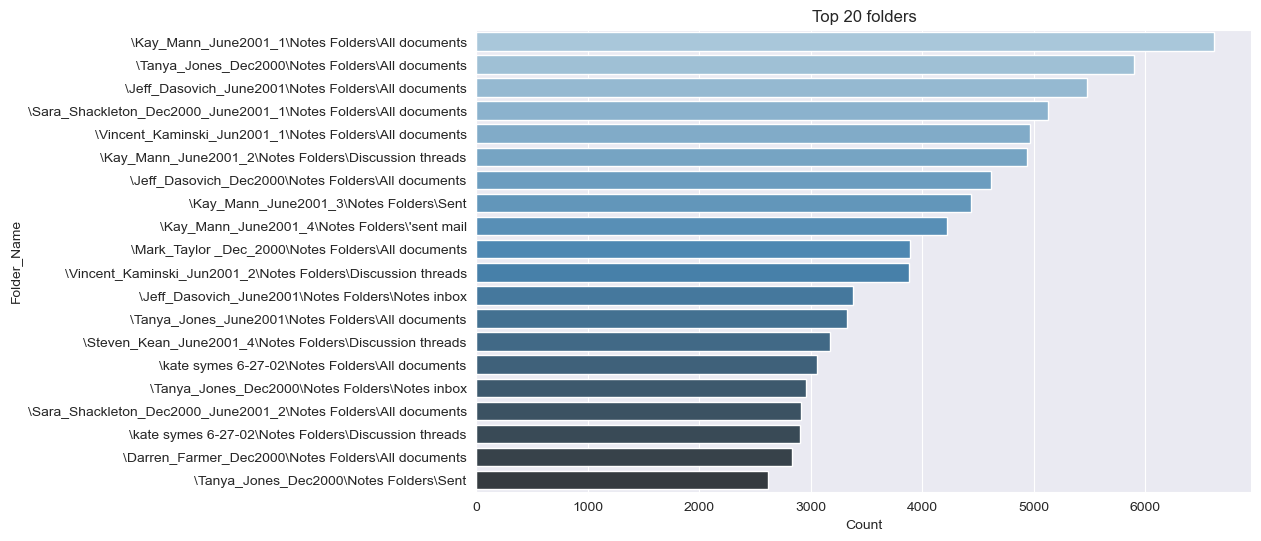

In [129]:
plt.figure(figsize=(10,6))
sns.barplot(x='count', y='folder_name', data=unique_emails.iloc[:20, :], palette="Blues_d")
plt.title("Top 20 folders")
plt.xlabel("Count")
plt.ylabel("Folder_Name")
plt.show()

#### Visualize Messages sent across the years

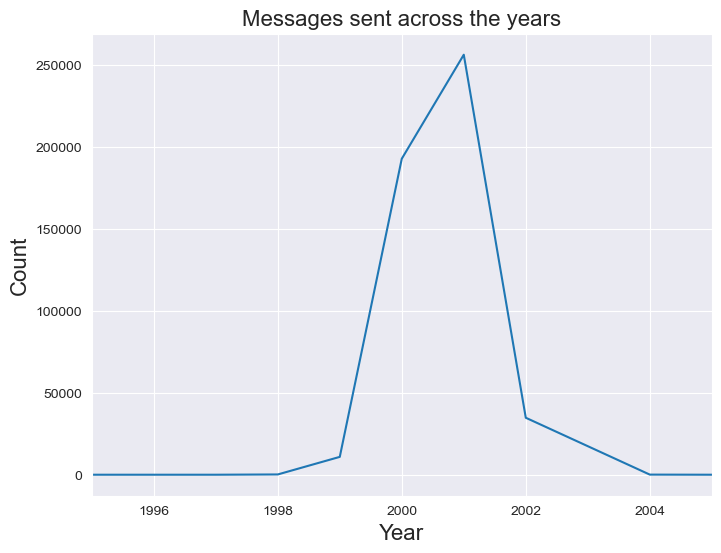

In [138]:
# make a diagram to show the count of messages sent per year
ax = df.groupby(df.Year)['X-Origin'].count().plot(figsize = (8,6))
ax.set_xlim(1995,2005)
ax.set_xlabel('Year', fontsize = 16)
ax.set_ylabel('Count', fontsize = 16)
ax.set_title('Messages sent across the years', fontsize = 16)
plt.show()

#### Messages Sent Across the Months Based on Year (1995-2005)

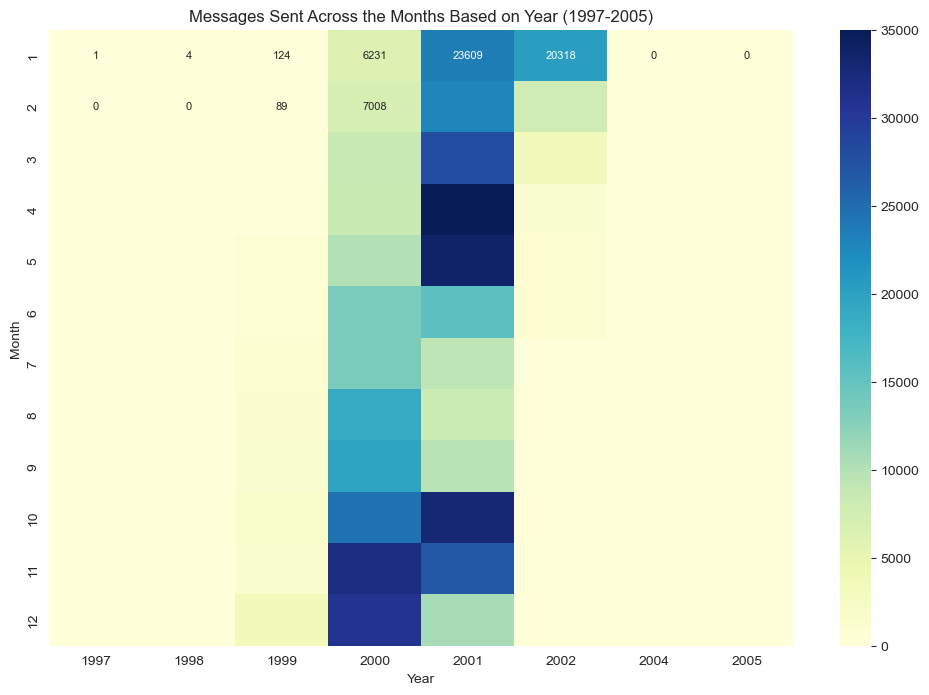

In [184]:
# Group the data by Year and Month and count the number of messages
monthly_counts = df.groupby(['Year', 'Month']).size().unstack(fill_value=0)

# Filter the data for the years 1997 to 2005
monthly_counts_filtered = monthly_counts.loc[1997:2005]

plt.figure(figsize=(12, 8))

# Create the heatmap with annotations for each value
sns.heatmap(monthly_counts_filtered.T, cmap='YlGnBu', annot=True, fmt='d', annot_kws={"size": 8})

plt.title('Messages Sent Across the Months Based on Year (1997-2005)')
plt.xlabel('Year')
plt.ylabel('Month')
plt.show()

#### Visualize Top 30 Senders

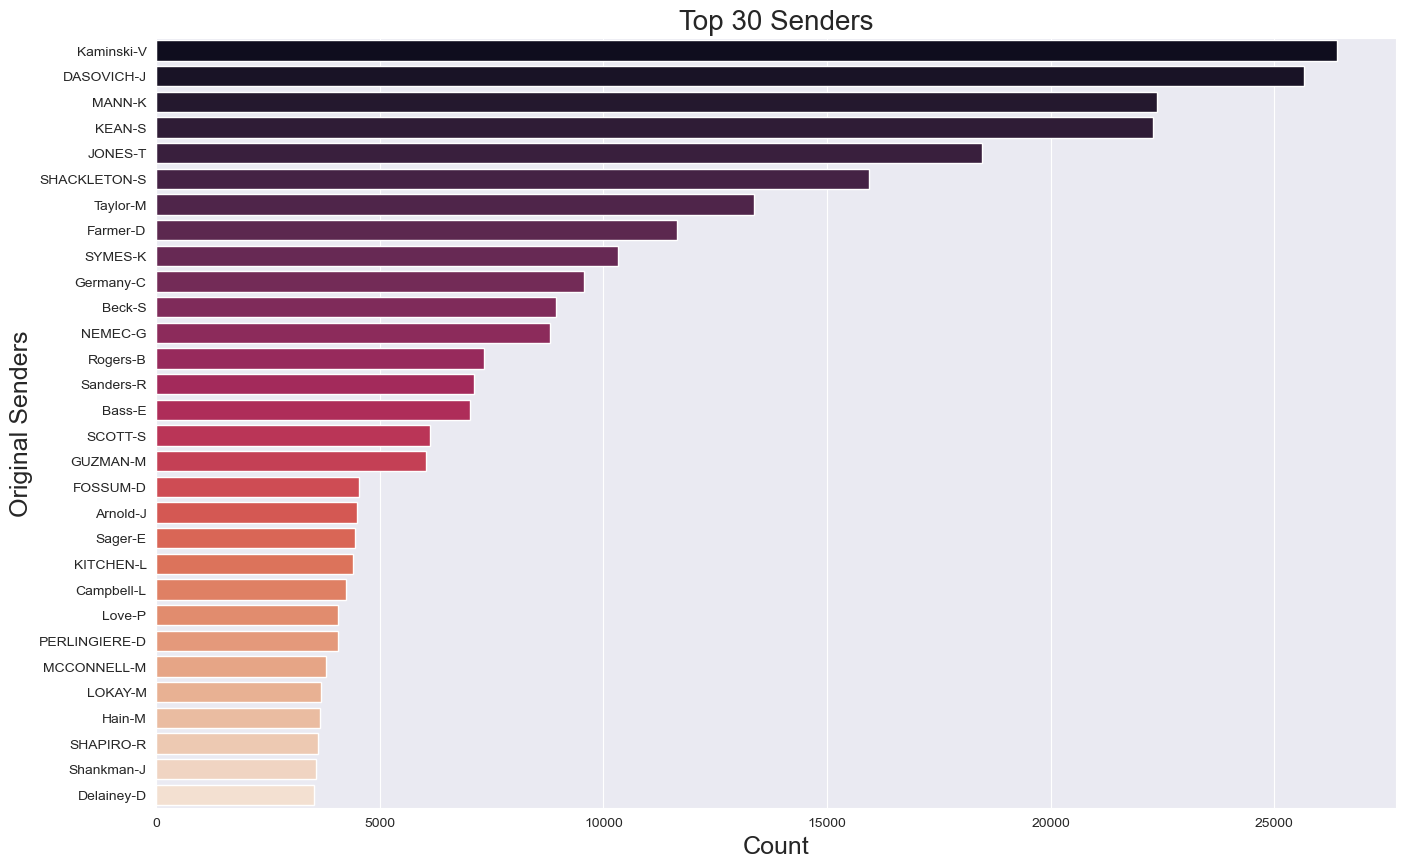

In [185]:
# diagram for showing top senders
plt.figure(figsize = (16,10))
ax = sns.barplot(x = df['X-Origin'].value_counts().values[:30], y = df['X-Origin'].value_counts().keys()[:30] ,palette = 'rocket', orient = 'h')
ax.set_xlabel('Count', fontsize = 18)
ax.set_ylabel('Original Senders', fontsize = 18)
ax.set_title('Top 30 Senders', fontsize = 20)
plt.show()

#### Visualize Top 30 Recepient emails

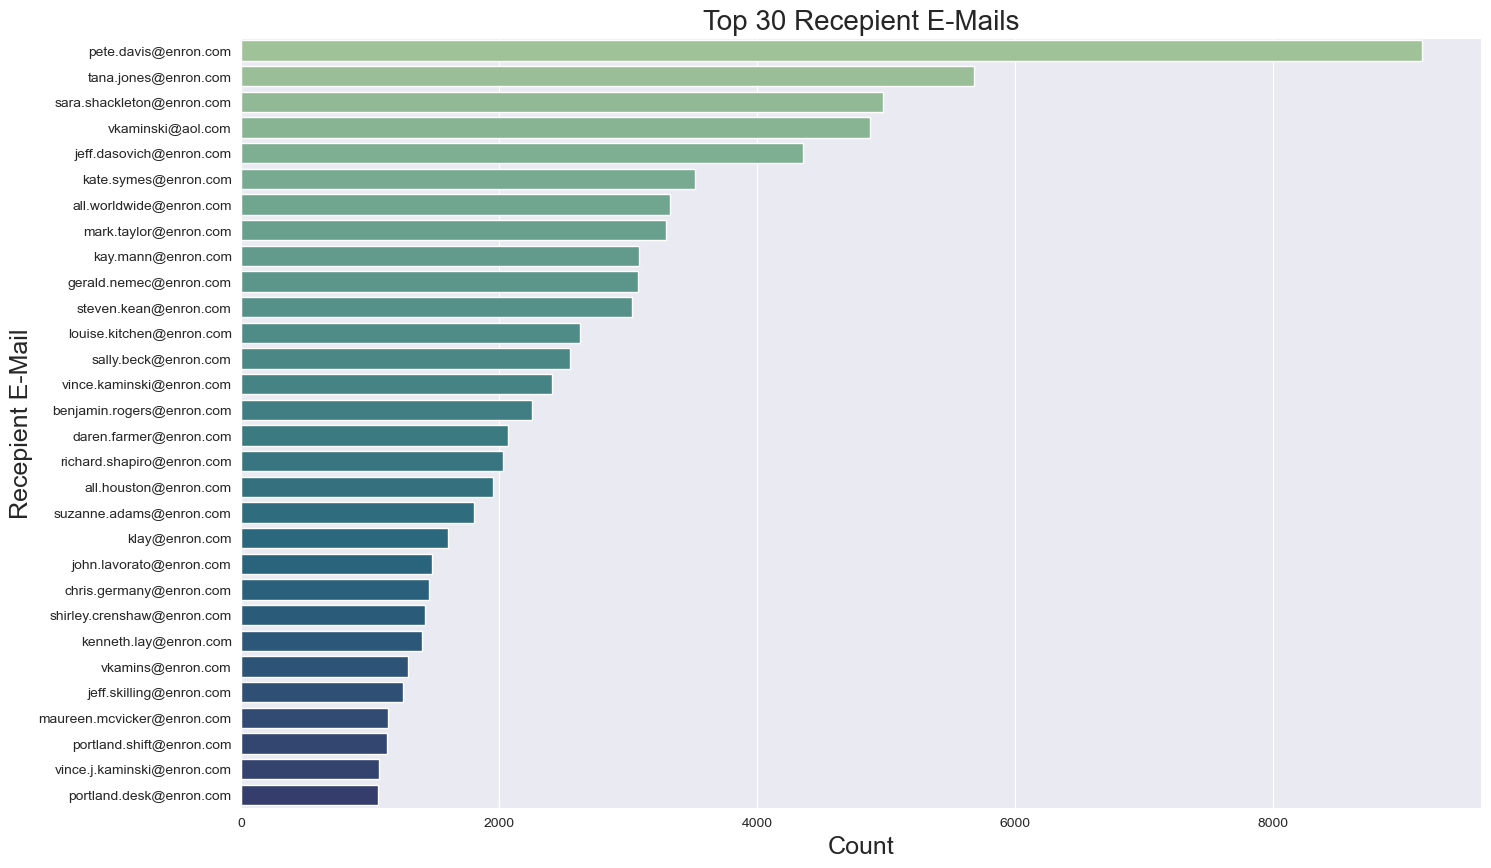

In [186]:
# diagram showing top recepients
plt.figure(figsize = (16,10))
ax = sns.barplot(x = df['To'].value_counts().values[:30], y = df['To'].value_counts().keys()[:30] ,palette = 'crest', orient = 'h')
ax.set_xlabel('Count', fontsize = 18)
ax.set_ylabel('Recepient E-Mail', fontsize = 18)
ax.set_title('Top 30 Recepient E-Mails', fontsize = 20)
plt.show()

#### Top 30 users based on their email count, along with their names and years.

In [187]:
userlist = df['X-Origin'].unique()

In [188]:
# Extract the year column values for each user
useryears = []
for user in userlist:
    year = df.loc[df['X-Origin'] == user, 'Year'].iloc[0]
    useryears.append(year)
    useryears

In [189]:
# Count the number of emails sent by each user
usercount = []
counter = 0
for name in userlist:
    for user in df['X-Origin'].values:
        if user == name:
            counter += 1
    usercount.append(counter)
    counter = 0

The `zip()` function combines elements from the three lists (userlist, usercount, and useryears) into tuples. Each tuple will have three elements: a user name, the count of emails sent, and the corresponding year.

Converts the zip object into a list of tuples. Each tuple in the list represents the user, their count, and the year.

contain a list of the top 30 users based on their email count, along with their names and years.

In [190]:
dataf = sorted(list(zip(userlist, usercount, useryears)), key= lambda user: user[1], reverse = True)[:30]

In [191]:
dataf = pd.DataFrame(dataf)
dataf.columns = ['User', 'Count', 'Year']
dataf.head()

,User,Count,Year
0,Kaminski-V,26409,2001
1,DASOVICH-J,25656,2001
2,MANN-K,22372,2001
3,KEAN-S,22296,2000
4,JONES-T,18475,2000


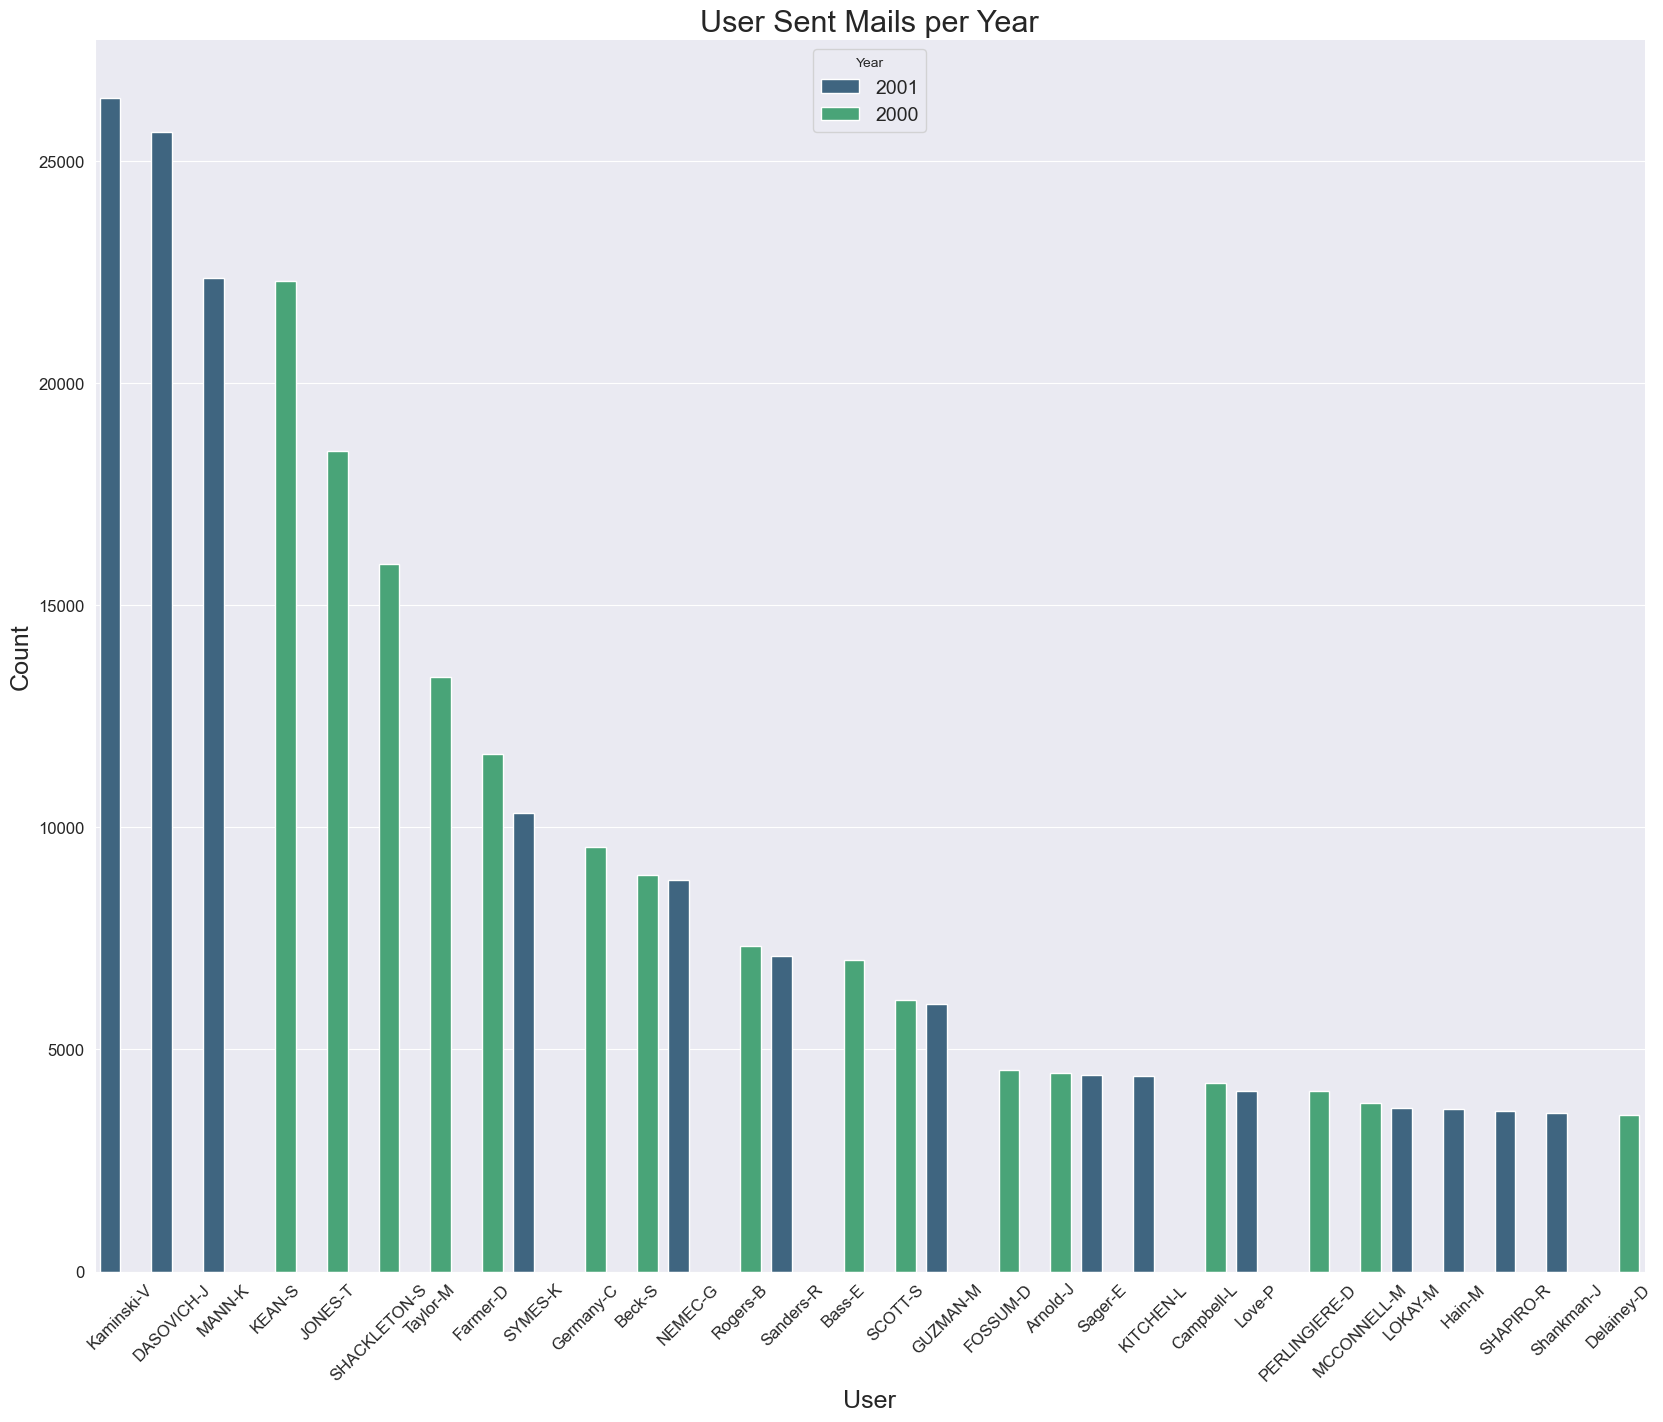

In [193]:
# Convert 'dataf' to a Pandas DataFrame
dataf_df = pd.DataFrame(dataf, columns=['User', 'Count', 'Year'])

# Ensure 'Year' is of type string for the hue parameter
dataf_df['Year'] = dataf_df['Year'].astype(str)

# Plot the barplot using the DataFrame
plt.figure(figsize=(20, 16))
ax = sns.barplot(data=dataf_df, x='User', y='Count', hue='Year', palette='viridis', saturation=0.7, dodge=True)

# Adjust plot aesthetics
sns.despine()
plt.xlabel('User', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.title('User Sent Mails per Year', fontsize=22)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Year', fontsize=14)
plt.show()